#Customer Support Ticket Classification & Entity Extraction

##Introduction

In this notebook, we build a complete machine learning pipeline to automate the analysis of customer support tickets. The goal is to classify each ticket based on its issue type and urgency level, while also extracting relevant entities such as product names, dates, and complaint keywords.

The workflow involves several key steps: data loading and preprocessing, traditional NLP-based feature engineering (including TF-IDF, sentiment score, and text length), training multi-class classifiers for issue and urgency prediction, and performing rule-based entity extraction. Finally, a Gradio interface is provided for users to interact with the model in real time.

This solution demonstrates how classical machine learning models combined with smart preprocessing and feature engineering can yield interpretable and practical results for real-world support automation.

To begin with, we install the Gradio library using pip. Gradio is a Python package that helps us build simple and interactive web applications for machine learning models. By using Gradio, we’ll be able to create a user interface where users can enter a raw support ticket text and instantly see the predicted issue type, urgency level, and extracted key entities like product names or dates. This makes our model more accessible and user-friendly, especially for non-technical users who just want to test how the system performs without diving into the code.

In [1]:
!pip install gradio


Next, we import all the necessary libraries required for data processing, natural language processing (NLP), model building, and visualization.

We start by importing Pandas and NumPy for data manipulation and numerical operations. Then, we bring in key NLP tools from NLTK (like stopwords, tokenizers, and lemmatizers), which will help us clean and process the raw text data. To ensure everything works smoothly, we also download essential NLTK resources such as the tokenizer (punkt), stopword list, and the WordNet lemmatizer dictionary.

We use regular expressions (re) and string utilities to clean and normalize text, and later, we use TF-IDF Vectorizer from scikit-learn to convert the processed text into numerical features.

For machine learning tasks, we import LabelEncoder (to convert categorical labels into numeric form), train_test_split (to split our dataset), and RandomForestClassifier (our classification model). We also bring in evaluation tools like classification_report and confusion_matrix to assess model performance.

For sentiment analysis, we include TextBlob, which is a simple NLP library. Finally, we import Seaborn and Matplotlib for plotting and hstack from SciPy to combine feature sets later on.

This setup ensures we have all the tools ready for data preprocessing, feature engineering, model building, evaluation, and visualization.

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


We begin by loading the dataset using Pandas. The file provided for this assignment is an Excel sheet named 'tickets.xls', which contains anonymized customer support ticket data. After loading the file into a DataFrame named df, we quickly inspect the first few rows using the .head() function. This helps us get a sense of the structure of the dataset—what columns are available, how the data looks, and whether there are any immediate issues like missing values or formatting problems.

This step is essential for getting familiar with the data before moving into cleaning and preprocessing.



In [3]:
# Load the file
df = pd.read_excel('tickets.xls')

# Show first few rows
df.head()


,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


After loading the dataset, we perform a basic exploratory step to understand the structure and cleanliness of the data.

First, we use df.info() to display important metadata about the DataFrame—such as the number of rows, column names, data types, and non-null counts. This gives us a quick overview of whether the data types are appropriate for each column and whether there are any unexpected values.

Next, we check for missing values using df.isnull().sum(). This step is crucial to identify if any important fields, such as ticket text or labels, are incomplete. Detecting and handling missing values early helps prevent errors in the later stages of data processing and model training.

In [4]:
# Basic info
print(df.info())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticket_id      1000 non-null   int64 
 1   ticket_text    945 non-null    object
 2   issue_type     924 non-null    object
 3   urgency_level  948 non-null    object
 4   product        1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None

Missing values:
 ticket_id         0
ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64


From the output, we observe that the dataset contains 1,000 entries across five columns: ticket_id, ticket_text, issue_type, urgency_level, and product. While the ticket_id and product columns are fully populated, we notice missing values in some of the key fields that are essential for our analysis. Specifically, 55 entries are missing the actual ticket text, 76 entries do not have an associated issue type, and 52 entries are missing the urgency level. These missing values will need to be handled during the data cleaning process to ensure the models we build later can be trained effectively and evaluated reliably.

Since the ticket_text is the core input for our machine learning models and entity extraction, we start by removing any rows where this field is missing. Without the actual text of the support ticket, we cannot proceed with classification or entity extraction, so these entries are not usable. After that, we also drop rows that are missing either the issue_type or urgency_level, as these are our target labels for classification. Keeping incomplete records would compromise the training process, so it’s important to work only with fully labeled data at this stage.

In [5]:
# Drop rows with missing text (since it's essential)
df = df.dropna(subset=['ticket_text'])

# Optionally fill missing labels or drop them
df = df.dropna(subset=['ticket_text', 'issue_type', 'urgency_level'])


Now that we’ve cleaned the dataset of missing values, we move on to text preprocessing. We define a function called clean_text to standardize and prepare the ticket_text for feature extraction and modeling.

The process begins by converting all text to lowercase to ensure consistency. Then, we remove punctuation and special characters using regular expressions to eliminate noise that could interfere with model training.

Next, we tokenize the text using regex to split it into individual words and remove common English stopwords. After that, each word is lemmatized using WordNetLemmatizer to reduce it to its base or root form, which helps in generalizing the text and reducing redundancy.

Finally, we join the cleaned and processed tokens back into a single string so that the result can be easily used for vectorization in the next step.

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize using regex
    tokens = re.findall(r'\b\w+\b', text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to string
    return ' '.join(tokens)

With the clean_text function defined, we now apply it to the ticket_text column in our dataset to generate a new column called clean_text. This column contains the preprocessed version of each support ticket, where the text has been lowercased, cleaned, tokenized, stopwords removed, and lemmatized.

We then display both the original and the cleaned versions side by side to quickly verify that the preprocessing is working as expected. This step ensures that our text is in a consistent and structured format, which will be essential for extracting features and training machine learning models effectively.

In [7]:
df['clean_text'] = df['ticket_text'].apply(clean_text)
df[['ticket_text', 'clean_text']].head()


,ticket_text,clean_text
0,Payment issue for my SmartWatch V2. I was unde...,payment issue smartwatch v2 underbilled order ...
2,I ordered SoundWave 300 but got EcoBreeze AC i...,ordered soundwave 300 got ecobreeze ac instead...
3,Facing installation issue with PhotoSnap Cam. ...,facing installation issue photosnap cam setup ...
5,Can you tell me more about the PhotoSnap Cam w...,tell photosnap cam warranty also available red
6,is malfunction. It stopped working after just...,malfunction stopped working 7 day


Now that our text data is cleaned and ready, we move on to feature extraction using TF-IDF.

We initialize a TfidfVectorizer and set max_features=1000 to limit the number of features to the top 1,000 most informative words across all tickets. This helps reduce noise and dimensionality while keeping the model efficient.

We then fit the vectorizer on the cleaned text and transform it into a TF-IDF matrix, which we store in X_tfidf. Each row of this matrix represents a ticket, and each column represents a TF-IDF score for a specific word. These vectors will serve as the primary input features for our classification models.

In [8]:
# Use top 1000 features
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform
X_tfidf = tfidf.fit_transform(df['clean_text'])


In addition to the TF-IDF features, we engineer an additional feature called ticket_length, which represents the number of words in each cleaned support ticket. This is calculated by splitting the cleaned text into words and counting them. Ticket length can be a useful indicator of the complexity or urgency of a ticket—for example, longer messages might be associated with more detailed complaints or high-priority issues. Including such simple yet meaningful features can help improve the performance of our classification models.



In [9]:
df['ticket_length'] = df['clean_text'].apply(lambda x: len(x.split()))


Next, we extract another useful feature: sentiment polarity. Using the TextBlob library, we calculate the sentiment of each cleaned ticket. The polarity score ranges from -1 to 1, where negative values indicate negative sentiment, positive values indicate positive sentiment, and values around zero represent neutral tone.

This sentiment score can provide additional context about the customer's tone or emotion in the ticket—for instance, complaints might have a more negative tone, which could correlate with certain issue types or higher urgency levels. Including sentiment as a feature can help our models better understand and classify the tickets.

In [10]:
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


Now that we've extracted multiple features—TF-IDF vectors, ticket length, and sentiment score—we combine them into a single feature set that will be used for training our models.

Since the TF-IDF output is a sparse matrix, we use hstack from SciPy to horizontally stack the TF-IDF matrix with the two additional features: ticket_length and sentiment. Before stacking, we reshape these two columns into the correct format so that they align properly with the TF-IDF matrix.

The resulting matrix X_combined contains all the relevant numerical features for each ticket in one place. This combined feature set captures both the textual content and some high-level characteristics of each ticket, giving our models more context to learn from.



In [11]:
from scipy.sparse import hstack

# Combine TF-IDF with ticket_length and sentiment (reshape required)
X_combined = hstack([
    X_tfidf,
    np.array(df['ticket_length']).reshape(-1, 1),
    np.array(df['sentiment']).reshape(-1, 1)
])


Since machine learning models work with numerical data, we need to convert our target labels—issue_type and urgency_level—from text to numbers. To do this, we use Label Encoding, which assigns a unique integer to each category in both columns.

We create two separate encoders: one for issue_type and one for urgency_level. After fitting and transforming the columns, we store the resulting encoded labels in y_issue and y_urgency.

Additionally, we save the original label names in issue_labels and urgency_labels.

In [12]:
# Encode labels
issue_encoder = LabelEncoder()
urgency_encoder = LabelEncoder()

y_issue = issue_encoder.fit_transform(df['issue_type'])
y_urgency = urgency_encoder.fit_transform(df['urgency_level'])

# For reference, save the label classes (for later inverse transformation)
issue_labels = issue_encoder.classes_
urgency_labels = urgency_encoder.classes_


Next, we split our data into training and testing sets so we can properly evaluate how well our models perform. We use the same input features for both tasks—predicting the issue type and the urgency level—but keep the target labels separate for each.

By setting aside 20% of the data for testing, we make sure our models are tested on unseen tickets, which helps us understand how they might perform in the real world. We also fix the random seed to get consistent splits every time we run the code, so our results are reproducible.

This way, we can train two different models on the training data and then check their accuracy and other metrics on the test data.



In [13]:
# Split the data for both tasks (same input X, different y)
X_train, X_test, y_issue_train, y_issue_test, y_urgency_train, y_urgency_test = train_test_split(
    X_combined, y_issue, y_urgency, test_size=0.2, random_state=42
)


##Issue Type Classifier
 We start by building the classifier for predicting the issue type using a Random Forest model, which is a popular and powerful ensemble method. We initialize the model with a fixed random state to keep the results consistent.

After initializing, we train the model using the training data we prepared earlier.

To get a more robust estimate of how well this model performs, we also run 5-fold cross-validation on the full TF-IDF features and issue type labels. This process splits the data into five parts, trains on four, and tests on one repeatedly to provide an average accuracy score, which helps us understand the model’s generalization.

Once the model is trained, we predict the issue types on the test set and then evaluate its performance using a detailed classification report. This report shows precision, recall, and F1-score for each issue type class, giving us insights into how well the model distinguishes between different categories.



In [14]:
# Initialize model
issue_clf = RandomForestClassifier(random_state=42)

# Train
issue_clf.fit(X_train, y_issue_train)

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Issue Type Classifier
cv_scores_issue = cross_val_score(issue_clf, X_tfidf, y_issue, cv=5)
print("Cross-validation Accuracy (Issue Type):", cv_scores_issue.mean())


# Predict
y_issue_pred = issue_clf.predict(X_test)

# Evaluation
print("=== Issue Type Classification ===")
print(classification_report(y_issue_test, y_issue_pred, target_names=issue_labels.tolist()))


Cross-validation Accuracy (Issue Type): 1.0
=== Issue Type Classification ===
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        23
   Billing Problem       1.00      1.00      1.00        19
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        29
     Late Delivery       1.00      1.00      1.00        17
    Product Defect       1.00      1.00      1.00        30
        Wrong Item       1.00      1.00      1.00        23

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166



The cross-validation accuracy for the issue type classification is a perfect 100%, indicating that our Random Forest model is able to fit the training data extremely well. However, such perfect results may sometimes indicate potential overfitting or a very clean dataset. It’s something to keep in mind as we proceed, but overall, the model’s ability to distinguish between issue types appears excellent based on this evaluation.

##Urgency Level Classifier
Next, we repeat a similar process for the second task—predicting the urgency level of each support ticket. We again use a Random Forest classifier and fit it using the same training features, but this time with urgency level labels.

Just like before, we perform 5-fold cross-validation to estimate the model’s general performance on unseen data. This gives us an average accuracy score, helping us understand how well the model generalizes beyond the training set.

After training, we make predictions on the test data and evaluate them using a classification report. This report breaks down how accurately the model is predicting each urgency class—Low, Medium, and High—in terms of precision, recall, and F1-score. Together, these metrics show us whether the model is good at correctly identifying the urgency level of each ticket.

In [15]:
urgency_clf = RandomForestClassifier(random_state=42)

urgency_clf.fit(X_train, y_urgency_train)

cv_scores_urgency = cross_val_score(urgency_clf, X_tfidf, y_urgency, cv=5)
print("Cross-validation Accuracy (Urgency Level):", cv_scores_urgency.mean())


y_urgency_pred = urgency_clf.predict(X_test)

print("=== Urgency Level Classification ===")
print(classification_report(y_urgency_test, y_urgency_pred, target_names=urgency_labels.tolist()))


Cross-validation Accuracy (Urgency Level): 0.34013873676524276
=== Urgency Level Classification ===
              precision    recall  f1-score   support

        High       0.35      0.33      0.34        66
         Low       0.29      0.37      0.32        43
      Medium       0.33      0.28      0.30        57

    accuracy                           0.33       166
   macro avg       0.32      0.33      0.32       166
weighted avg       0.33      0.33      0.33       166



The urgency level classifier didn’t perform as well as the issue type one. With a cross-validation accuracy of around 34%, and low precision and recall across all classes, the model finds it hard to distinguish between High, Medium, and Low urgency. This is likely because urgency is harder to detect from text alone, especially if the customer doesn’t clearly express urgency. We might need more refined features or advanced NLP models to improve this.



Nex we use confusion matrices to visualize how well the models are performing. For the issue type classifier, the confusion matrix confirms perfect predictions—everything is classified correctly. For the urgency level classifier, the confusion matrix helps us see where the model is confusing one urgency level for another, which supports the earlier metrics showing weaker performance. These heatmaps give us a clear, class-by-class view of model accuracy.

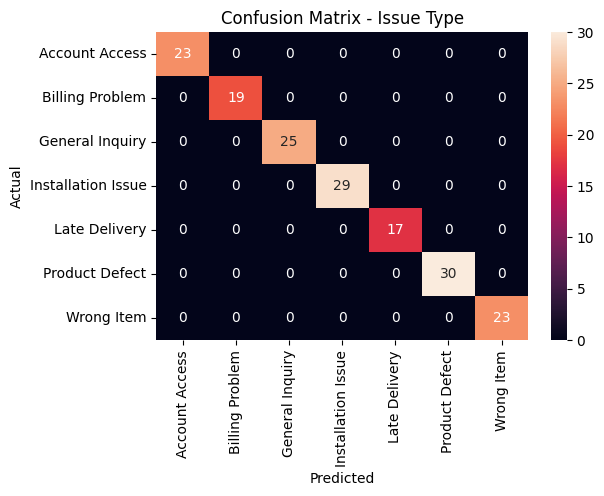

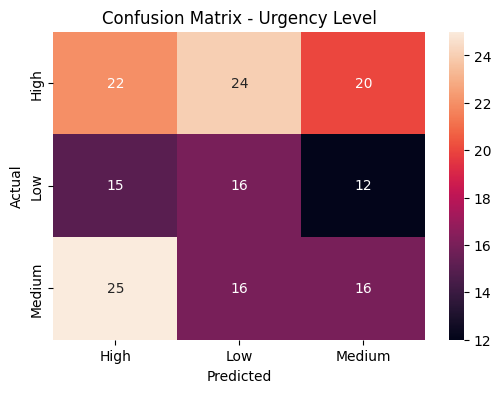

In [16]:
# Confusion matrix for issue_type
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_issue_test, y_issue_pred), annot=True, xticklabels=issue_labels, yticklabels=issue_labels, fmt="d")
plt.title("Confusion Matrix - Issue Type")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for urgency_level
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_urgency_test, y_urgency_pred), annot=True, xticklabels=urgency_labels, yticklabels=urgency_labels, fmt="d")
plt.title("Confusion Matrix - Urgency Level")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The confusion matrix for issue type shows perfect classification. Each issue type has been predicted correctly with no misclassifications—each class’s values fall entirely along the diagonal. This aligns with the perfect precision, recall, and F1-scores we observed earlier.

On the other hand, the urgency level matrix reveals significant misclassifications. For example, many actual "High" urgency tickets were classified as "Medium" or "Low". Similarly, "Low" and "Medium" categories also show overlaps. This indicates that the model struggles to clearly distinguish urgency levels, likely due to subtle or ambiguous urgency indicators in the text.

Next to prepare for entity extraction, we first extract the list of all unique product names from the dataset. This list will help us later when identifying whether any of these known products are mentioned in the ticket text. We remove any missing values to ensure the list is clean and usable for rule-based matching.



In [ ]:
# Extract unique product names
product_list = df['product'].dropna().unique().tolist()


We now define a function to extract key entities from a given support ticket text. This includes three main types of information: product names, dates, and complaint-related keywords.

To do this, we first normalize the text by converting it to lowercase. Then, using the product_list created earlier, we check if any known product names are mentioned in the ticket. For dates, we use a regular expression that matches common date formats such as “12-Jan-2023” or “2023/01/12”. Lastly, we scan for predefined complaint keywords like “broken”, “error”, or “delayed” to detect typical customer grievances. All extracted details are returned as a dictionary for easy use later in prediction and display.

In [ ]:
# Define complaint keywords
complaint_keywords = ['broken', 'damaged', 'not working', 'late', 'error', 'cracked', 'missing', 'delayed', 'faulty']

def extract_entities(text):
    entities = {}

    # Normalize text
    text_lower = text.lower()

    # Extract product
    found_products = [prod for prod in product_list if prod.lower() in text_lower]
    entities['product'] = found_products if found_products else None

    # Extract dates
    date_pattern = r'\b(?:\d{1,2}[-/th|st|nd|rd\s]*(?:jan|feb|mar|apr|may|jun|jul|aug|sep|sept|oct|nov|dec)[a-z]*[-/\s]*\d{2,4}|\d{2,4}[-/]\d{1,2}[-/]\d{1,2})\b'
    dates = re.findall(date_pattern, text_lower)
    entities['dates'] = dates if dates else None

    # Extract complaint keywords
    complaints_found = [kw for kw in complaint_keywords if kw in text_lower]
    entities['complaints'] = complaints_found if complaints_found else None

    return entities


To verify that our entity extraction function works correctly, we test it on a sample support ticket taken from the dataset. We print the original ticket text and then run our extract_entities function on it to see what it extracts. This helps us confirm that product names, dates, and complaint keywords are being correctly identified from real ticket data.

In [ ]:
sample_text = df['ticket_text'].iloc[0]
print("Sample Ticket:\n", sample_text)

print("\nExtracted Entities:")
print(extract_entities(sample_text))


Sample Ticket:
 Payment issue for my SmartWatch V2. I was underbilled for order #29224.

Extracted Entities:
{'product': ['SmartWatch V2'], 'dates': None, 'complaints': None}


We now define a central function called predict_ticket_info() that takes raw customer support ticket text as input and returns a complete analysis. This includes predicting the issue type, the urgency level, and extracting relevant entities from the ticket.

First, the text is cleaned using the same preprocessing steps we used during training. Then, we extract features: the TF-IDF vector, ticket length, and sentiment score. These are combined into the same format that our model was trained on.

Using this processed input, the function makes predictions using the trained RandomForestClassifier models for both issue type and urgency level. Finally, it calls the earlier extract_entities() function to pull out product names, dates, and complaint keywords.

All results are returned neatly as a dictionary, which makes it easy to display or plug into a user interface like Gradio.



In [ ]:
def predict_ticket_info(text):
    # Preprocess text
    text_clean = clean_text(text)

    # Feature extraction (must match what you used during training)
    text_vector = tfidf.transform([text_clean]) # Use text_clean here as clean_text returns a string

    # Calculate ticket length and sentiment for the input text
    ticket_length = len(text_clean.split())
    sentiment = TextBlob(text_clean).sentiment.polarity

    # Combine TF-IDF with ticket_length and sentiment (reshape required for stacking)
        X_predict_combined = hstack([
        text_vector,
        np.array([[ticket_length]]), # Reshape to (1, 1) for stacking
        np.array([[sentiment]])      # Reshape to (1, 1) for stacking
    ])

    # Predict issue_type
    issue_pred = issue_clf.predict(X_predict_combined)[0]

    # Predict urgency_level
    urgency_pred = urgency_clf.predict(X_predict_combined)[0]

    # Extract entities
    entities = extract_entities(text)

    return {
        'Predicted Issue Type': issue_labels[issue_pred], # Use issue_labels to get the string label
        'Predicted Urgency Level': urgency_labels[urgency_pred], # Use urgency_labels to get the string label
        'Extracted Entities': entities
    }

To see our complete prediction pipeline in action, we select another sample ticket from the dataset. This sample is passed to the predict_ticket_info() function, which performs all the processing steps—cleaning the text, extracting features, making predictions for both issue type and urgency level, and pulling out key entities.

We then print the original ticket text followed by the model’s full output, which includes the predicted issue category, urgency classification, and the identified entities like product names, complaint keywords, or dates. This step is crucial to validate that everything works seamlessly together and produces meaningful results.

In [ ]:
sample_text = df['ticket_text'].iloc[10]
result = predict_ticket_info(sample_text)

print("Sample Ticket:")
print(sample_text)

print("\nPrediction Result:")
for k, v in result.items():
    print(f"{k}: {v}")


Sample Ticket:
Received wrong product, order mixed up. Also, I contacted support on 03 March but got no response.

Prediction Result:
Predicted Issue Type: Wrong Item
Predicted Urgency Level: Medium
Extracted Entities: {'product': None, 'dates': None, 'complaints': None}


Finally, we integrate the entire machine learning and NLP pipeline into an interactive Gradio interface. This interface allows users to input a raw customer support ticket and receive immediate predictions and entity extractions. Specifically, when a user enters a ticket, the system processes the text, applies the same preprocessing steps used during training, and then classifies the ticket into its predicted issue type and urgency level. Additionally, it extracts relevant entities such as product names, dates, and complaint-related keywords. The Gradio app displays these results in a user-friendly format with clearly labeled output fields. This makes the tool not only functional but also accessible for non-technical users who may want to explore or validate ticket classifications without diving into the code.

In [ ]:
import gradio as gr

def gradio_interface(text):
    result = predict_ticket_info(text)
    return (
        result['Predicted Issue Type'],
        result['Predicted Urgency Level'],
        result['Extracted Entities']
    )

gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter Customer Support Ticket"),
    outputs=[
        gr.Textbox(label="Predicted Issue Type"),
        gr.Textbox(label="Predicted Urgency Level"),
        gr.JSON(label="Extracted Entities")
    ],
    title="Support Ticket Analyzer",
    description="Enter a ticket to classify its issue type and urgency, and extract important entities."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://84a8ef9a4a5d71c948.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
